In [114]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from sklearn import metrics
from captum.attr import IntegratedGradients

In [115]:
NUMBER_OF_HIDDEN_UNITS = 64
LEARNING_RATE = 0.9
batch_size = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("available device: ", device)

# For the explainable AI
# Analyze the neural net model for the following interesting time indices:
# pressure_drop_target_indices_fulltrainvaltestlist = [5001, 7024, 10411, 18296, 19620, 22527, 25524, 28325, 38920, 39582, 39583, 43157, 43158, 45678, 46523, 48914, 48915, 49744, 50323]

test_pressure_drop_target_indices = [56, 2447, 2448, 3277, 3856]
target_index = test_pressure_drop_target_indices[4] # What time step do you want to focus on and analyze


available device:  cpu


# <span style="color:red">Section 1: Test model on unseen dataset</span>

In [116]:
df_train_minmax = pd.HDFStore("../../cloudcontainer/concatenated_experiments.hdf5", mode='r').select("alldata_mean_instead_of_NaN/train/minmax")
df_pressure_train_minmax = df_train_minmax["pressure"]
df_ae_train_minmax = df_train_minmax["ae"]

df_val_minmax = pd.HDFStore("../../cloudcontainer/concatenated_experiments.hdf5", mode='r').select("alldata_mean_instead_of_NaN/val/minmax")
df_pressure_val_minmax = df_val_minmax["pressure"]
df_ae_val_minmax = df_val_minmax["ae"]

df_test_minmax = pd.HDFStore("../../cloudcontainer/concatenated_experiments.hdf5", mode='r').select("alldata_mean_instead_of_NaN/test/minmax")
df_pressure_test_minmax = df_test_minmax["pressure"]
df_ae_test_minmax = df_test_minmax["ae"]

df_train_minmax = df_train_minmax.drop(["pressure"], axis=1)
df_val_minmax = df_val_minmax.drop(["pressure"], axis=1)
df_test_minmax = df_test_minmax.drop(["pressure"], axis=1)
#df_train_minmax = df_train_minmax.drop(["ae"], axis=1)
#df_val_minmax = df_val_minmax.drop(["ae"], axis=1)
#df_test_minmax = df_test_minmax.drop(["ae"], axis=1)
feature_names = df_train_minmax.columns.to_list()
print(f"Feature names: {feature_names}")

np_train_minmax = df_train_minmax.to_numpy()
np_pressure_train_minmax = df_pressure_train_minmax.to_numpy()
np_ae_train_minmax = df_ae_train_minmax.to_numpy()

np_val_minmax = df_val_minmax.to_numpy()
np_pressure_val_minmax = df_pressure_val_minmax.to_numpy()
np_ae_val_minmax = df_ae_val_minmax.to_numpy()

np_test_minmax = df_test_minmax.to_numpy()
np_pressure_test_minmax = df_pressure_test_minmax.to_numpy()
np_ae_test_minmax = df_ae_test_minmax.to_numpy()

Feature names: ['ae', 's0.5/w180/n_N', 's0.5/w23/n_N', 's0.5/w45/n_N', 's0.5/w90/n_N', 's0.5/w180/rc5/c_C-VALUE', 's0.5/w45/rc10/c_C-VALUE', 's0.5/w45/rc20/c_C-VALUE', 's0.5/w90/rc20/c_C-VALUE', 's0.5/w90/rc5/c_C-VALUE', 's0.5/w100/pfo_PFO', 's0.5/w25/pfo_PFO', 's0.5/w50/pfo_PFO', 's0.5/w100/pma_PMA', 's0.5/w25/pma_PMA', 's0.5/w50/pma_PMA', 's0.5/w180/sr_SR', 's0.5/w90/sr_SR', 's0.5/w10/b_B-VALUE', 's0.5/w180/b_B-VALUE', 's0.5/w30/b_B-VALUE', 's0.5/w90/b_B-VALUE', 's0.5/w180/d2_D-VALUE', 's0.5/w45/d2_D-VALUE', 's0.5/w90/d2_D-VALUE', 's0.5/w180/s1d_S1D', 's0.5/w90/s1d_S1D', 's0.5/w100/trp_TRP', 's0.5/w25/trp_TRP', 's0.5/w50/trp_TRP', 's0.5/w100/trq_TRQ', 's0.5/w25/trq_TRQ', 's0.5/w50/trq_TRQ', 's0.5/w180/r_R', 's0.5/w23/r_R', 's0.5/w45/r_R', 's0.5/w90/r_R', 's0.5/w90/dm_DM', 's0.5/w100/paf_PAF', 's0.5/w25/paf_PAF', 's0.5/w50/paf_PAF', 's0.5/w100/vm_VM', 's0.5/w200/vm_VM', 's0.5/w180/svar_SVAR', 's0.5/w90/svar_SVAR', 's0.5/w180/rx2_R', 's0.5/w23/rx2_R', 's0.5/w45/rx2_R', 's0.5/w90/rx2_R'

In [117]:
train_series_len = len(np_pressure_train_minmax)
val_series_len = len(np_pressure_val_minmax)
test_series_len = len(np_pressure_test_minmax)

n_features = np_train_minmax.shape[1]
print("n_features=", n_features)

train_shift_step = int(train_series_len / batch_size)
val_shift_step = int(val_series_len / batch_size)
test_shift_step = int(test_series_len / batch_size)

shift_step = int(test_series_len / batch_size)
print("shift_step=", shift_step)

np_train_minmax_shifted = np.empty((batch_size, train_series_len, n_features), np.float64)
np_pressure_train_minmax_shifted = np.empty((batch_size, train_series_len), np.float64)
np_ae_train_minmax_shifted = np.empty((batch_size, train_series_len), np.float64)

np_val_minmax_shifted = np.empty((batch_size, val_series_len, n_features), np.float64)
np_pressure_val_minmax_shifted = np.empty((batch_size, val_series_len), np.float64)
np_ae_val_minmax_shifted = np.empty((batch_size, val_series_len), np.float64)

np_test_minmax_shifted = np.empty((batch_size, test_series_len, n_features), np.float64)
np_pressure_test_minmax_shifted = np.empty((batch_size, test_series_len), np.float64)
np_ae_test_minmax_shifted = np.empty((batch_size, test_series_len), np.float64)


for i in range(batch_size):
    rolling_amount = shift_step*i
    np_train_minmax_shifted[i] = np.roll(np_train_minmax, rolling_amount)
    np_pressure_train_minmax_shifted[i] = np.roll(np_pressure_train_minmax, rolling_amount)
    np_ae_train_minmax_shifted[i] = np.roll(np_ae_train_minmax, rolling_amount)

for i in range(batch_size):
    rolling_amount = shift_step*i
    np_val_minmax_shifted[i] = np.roll(np_val_minmax, rolling_amount)
    np_pressure_val_minmax_shifted[i] = np.roll(np_pressure_val_minmax, rolling_amount)
    np_ae_val_minmax_shifted[i] = np.roll(np_ae_val_minmax, rolling_amount)
    
for i in range(batch_size):
    rolling_amount = shift_step*i
    np_test_minmax_shifted[i] = np.roll(np_test_minmax, rolling_amount)
    np_pressure_test_minmax_shifted[i] = np.roll(np_pressure_test_minmax, rolling_amount)
    np_ae_test_minmax_shifted[i] = np.roll(np_ae_test_minmax, rolling_amount)

n_features= 49
shift_step= 5163


In [118]:
train_input_torch = torch.from_numpy(np_train_minmax_shifted[:, :-1,:]).to(device)
train_target_torch = torch.from_numpy(np_pressure_train_minmax_shifted[:, 1:]).to(device)

val_input_torch = torch.from_numpy(np_val_minmax_shifted[:, :-1,:]).to(device)
val_target_torch = torch.from_numpy(np_pressure_val_minmax_shifted[:, 1:]).to(device)

test_input_torch = torch.from_numpy(np_test_minmax_shifted[:, :-1,:]).to(device)
test_target_torch = torch.from_numpy(np_pressure_test_minmax_shifted[:, 1:]).to(device)

print(np_train_minmax_shifted.shape)
print(train_input_torch.shape)
print(train_target_torch.shape)

(1, 41304, 49)
torch.Size([1, 41303, 49])
torch.Size([1, 41303])


In [119]:
class DKRZSeismologyLSTM(nn.Module):
    def __init__(self, num_hidden=NUMBER_OF_HIDDEN_UNITS):
        super(DKRZSeismologyLSTM, self).__init__()
        self.num_hidden = num_hidden
        self.layer1 = nn.LSTMCell(49, self.num_hidden, dtype=torch.float64).to(device) # we will feed in one sample at a time, and then zero out the h and c variables after all train data points were seen.
        self.layer2 = nn.LSTMCell(self.num_hidden, self.num_hidden, dtype=torch.float64).to(device)
        self.out = nn.Linear(self.num_hidden, 1, dtype=torch.float64).to(device)

    def forward(self, x):
        #print("input x shape: ", x.size())
        num_batches = x.size(0)
        #print("num_batches", num_batches)
        output_list = []
        
        h_t1 = torch.zeros(num_batches, self.num_hidden, dtype=torch.float64).to(device)
        c_t1 = torch.zeros(num_batches, self.num_hidden, dtype=torch.float64).to(device)
        h_t2 = torch.zeros(num_batches, self.num_hidden, dtype=torch.float64).to(device)
        c_t2 = torch.zeros(num_batches, self.num_hidden, dtype=torch.float64).to(device)

        for input_split in x.split(1, dim=1):
            #print("input_split before:", input_split.size())
            input_split_reshaped = input_split.reshape(num_batches, 49)
            #print("input_split after:", input_split_reshaped.size())
            h_t1, c_t1 = self.layer1(input_split_reshaped, (h_t1, c_t1))
            h_t2, c_t2 = self.layer2(h_t1, (h_t2, c_t2))
            output = self.out(h_t2)
            output_list.append(output)

        outputs = torch.cat(output_list, dim=1)
        return outputs


In [120]:
seismology_model = DKRZSeismologyLSTM().to(device)
criterion = nn.MSELoss()

In [121]:
seismology_model = torch.load("../../cloudcontainer/experiments_related/best_seismology_model.pth", map_location=torch.device(device))
with torch.no_grad():
    interemdiary_train_pred = seismology_model(train_input_torch)
    intermediary_train_loss = criterion(interemdiary_train_pred, train_target_torch)
    print("intermediary_train_loss: ", intermediary_train_loss.item())
    np_pred_cpu_train = interemdiary_train_pred.detach().cpu().numpy()[0] # index 0 here means basically the original unshifted dataset
    target_cpu_train = train_target_torch.detach().cpu().numpy()[0] # index 0 here means basically the original unshifted dataset

    intermediary_val_pred = seismology_model(val_input_torch)
    intermediary_val_loss = criterion(intermediary_val_pred, val_target_torch)
    print("intermediary_val_loss: ", intermediary_val_loss.item())
    np_pred_cpu_val = intermediary_val_pred.detach().cpu().numpy()[0] # index 0 here means basically the original unshifted dataset
    target_cpu_val = val_target_torch.detach().cpu().numpy()[0] # index 0 here means basically the original unshifted dataset

    intermediary_test_pred = seismology_model(test_input_torch)
    intermediary_test_loss = criterion(intermediary_test_pred, test_target_torch)
    print("intermediary_test_loss: ", intermediary_test_loss.item())
    np_pred_cpu_test = intermediary_test_pred.detach().cpu().numpy()[0] # index 0 here means basically the original unshifted dataset
    target_cpu_test = test_target_torch.detach().cpu().numpy()[0] # index 0 here means basically the original unshifted dataset

# use sklearn MSE metrics to compare with the baseline using the same exact implementation of the metric:
mse_train = metrics.mean_squared_error(target_cpu_train, np_pred_cpu_train)
mse_val = metrics.mean_squared_error(target_cpu_val, np_pred_cpu_val)
mse_test = metrics.mean_squared_error(target_cpu_test, np_pred_cpu_test)
print("train mse: ", mse_train)
print("val mse: ", mse_val)
print("test mse: ", mse_test)
    
    

intermediary_train_loss:  0.00014298947452706158
intermediary_val_loss:  0.006753189055911695
intermediary_test_loss:  0.004185960203170997
train mse:  0.00014298947452706155
val mse:  0.006753189055911694
test mse:  0.004185960203170997


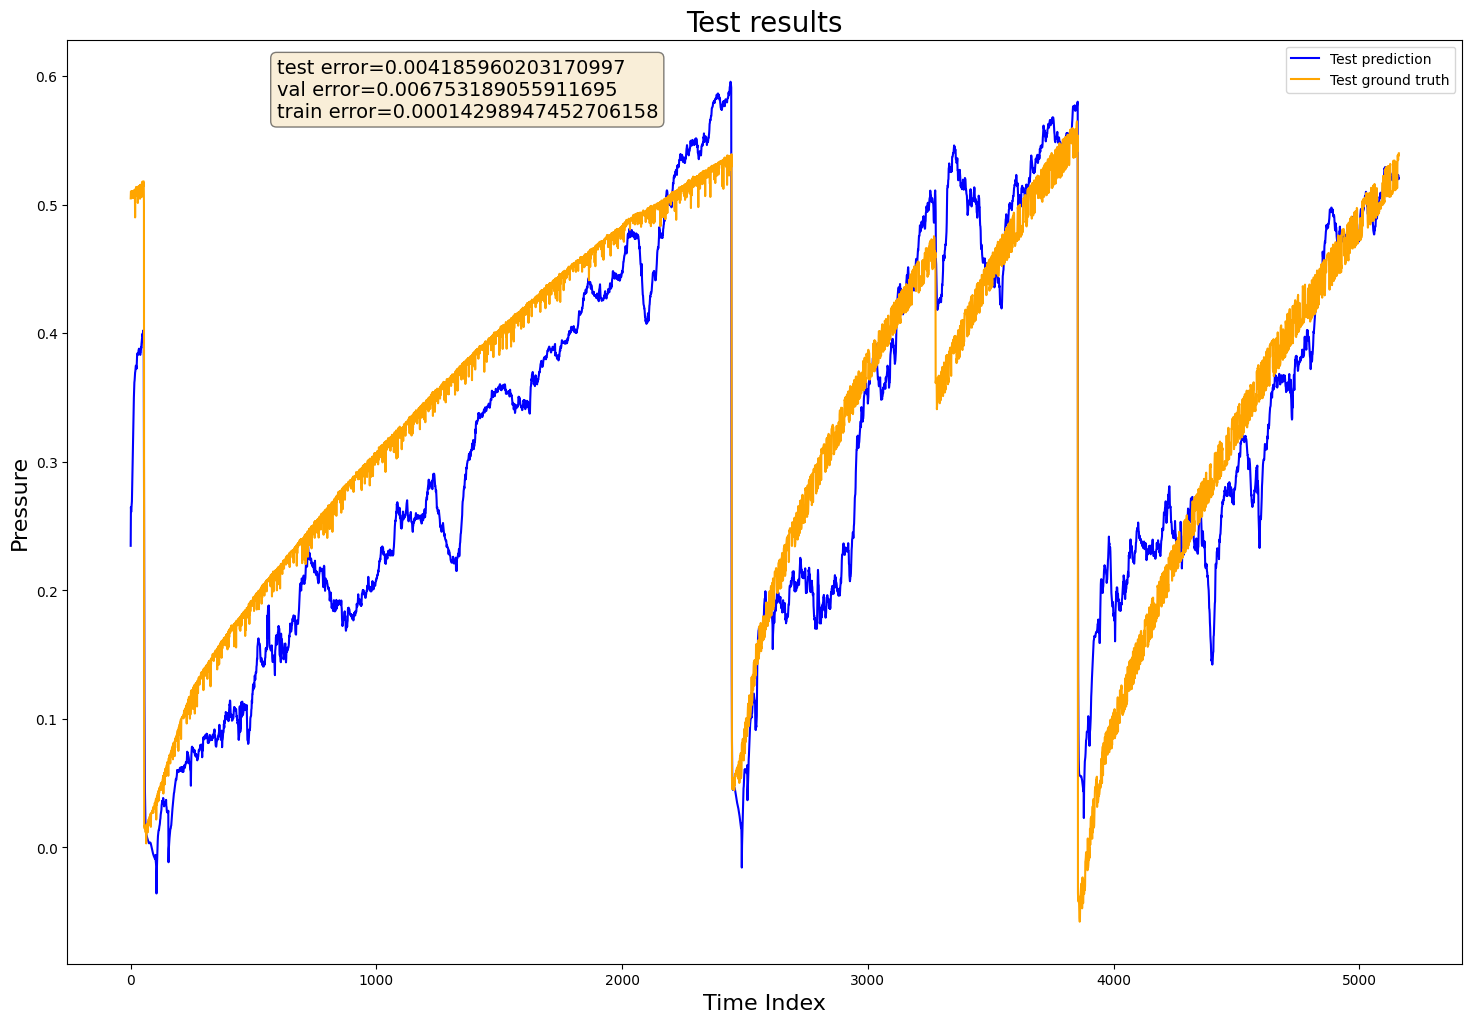

In [122]:
fig, ax = plt.subplots(figsize=(18, 12))
ax.plot(np_pred_cpu_test, color="blue", label="Test prediction")
ax.plot(target_cpu_test, color="orange", label="Test ground truth")

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
text_box_str = f"test error={intermediary_test_loss.item()}" + f"\nval error={intermediary_val_loss.item()}" + f"\ntrain error={intermediary_train_loss.item()}"
ax.text(0.15, 0.98, text_box_str, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)

ax.set_title(f"Test results", fontsize=20)
ax.set_xlabel("Time Index", fontsize=16)
ax.set_ylabel("Pressure", fontsize=16)
plt.legend()
plt.show()

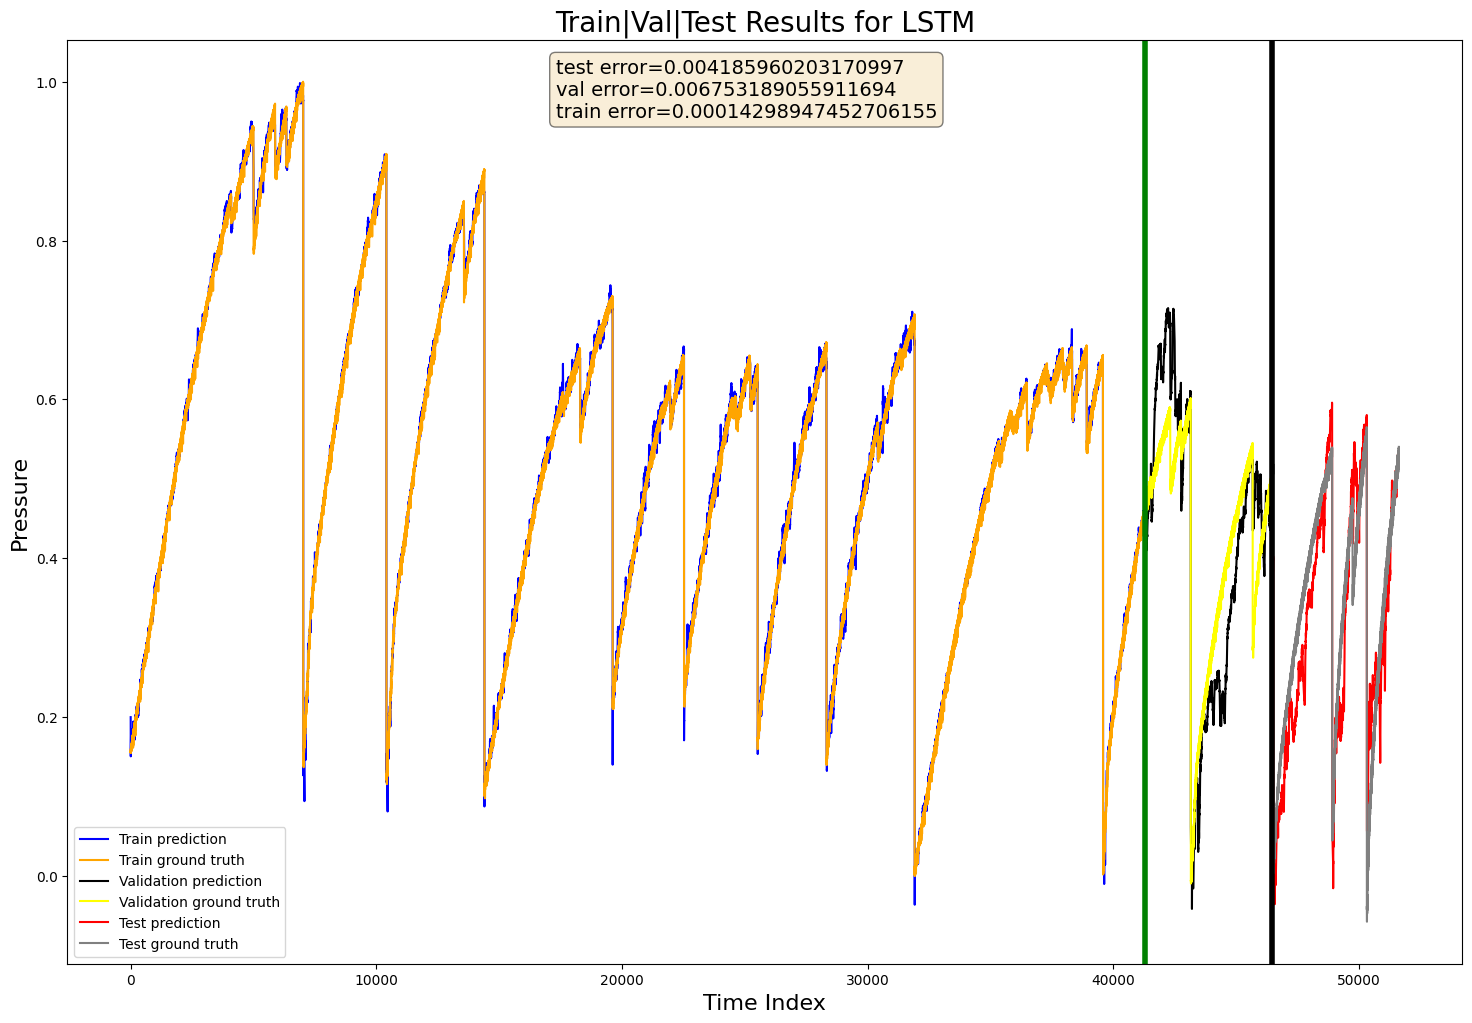

In [123]:
fig, ax = plt.subplots(figsize=(18, 12))
x_data = range(len(np_pred_cpu_train)+len(np_pred_cpu_val)+len(np_pred_cpu_test))

ax.plot(x_data[:len(np_pred_cpu_train)], np_pred_cpu_train, color="blue", label="Train prediction")
ax.plot(x_data[:len(np_pred_cpu_train)], target_cpu_train, color="orange", label="Train ground truth")

ax.plot(x_data[len(np_pred_cpu_train):len(np_pred_cpu_train)+len(np_pred_cpu_val)], np_pred_cpu_val, color="black", label="Validation prediction")
ax.plot(x_data[len(np_pred_cpu_train):len(np_pred_cpu_train)+len(np_pred_cpu_val)], target_cpu_val, color="yellow", label="Validation ground truth")

ax.plot(x_data[len(np_pred_cpu_train)+len(np_pred_cpu_val):], np_pred_cpu_test, color="red", label="Test prediction")
ax.plot(x_data[len(np_pred_cpu_train)+len(np_pred_cpu_val):], target_cpu_test, color="gray", label="Test ground truth")

ax.axvline(x=train_series_len, color='g', lw=4)
ax.axvline(x=train_series_len+val_series_len, color='black', lw=4)

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
text_box_str = f"test error={mse_test}" + f"\nval error={mse_val}" + f"\ntrain error={mse_train}"
ax.text(0.35, 0.98, text_box_str, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)

ax.set_title(f"Train|Val|Test Results for LSTM", fontsize=20)
ax.set_xlabel("Time Index", fontsize=16)
ax.set_ylabel("Pressure", fontsize=16)
plt.legend()
plt.show()


# <span style="color:red">Section 2: Explainabe AI</span>

In [124]:
# Could not make SHAP work for this LSTM model and therefore opted for captum Integrated Gradients, 
# specifically designed for pytorch.
"""
import shap
test_data_to_explain = test_input_torch[:, :101, :]
explainer = shap.GradientExplainer(seismology_model, test_data_to_explain)

shap_values = explainer.shap_values(test_data_to_explain)
for iteration_i, val in enumerate(shap_values):
    print("Iteration", iteration_i, "gives cumulated shap_val=", val.sum())
"""

'\nimport shap\ntest_data_to_explain = test_input_torch[:, :101, :]\nexplainer = shap.GradientExplainer(seismology_model, test_data_to_explain)\n\nshap_values = explainer.shap_values(test_data_to_explain)\nfor iteration_i, val in enumerate(shap_values):\n    print("Iteration", iteration_i, "gives cumulated shap_val=", val.sum())\n'

In [125]:
ig = IntegratedGradients(seismology_model)
baseline = torch.zeros_like(test_input_torch)
print(baseline.shape)

torch.Size([1, 5162, 49])


In [126]:
attributions, delta = ig.attribute(test_input_torch, target=target_index, return_convergence_delta=True)
print("attributions shape: ", attributions.shape)

attributions shape:  torch.Size([1, 5162, 49])


In [127]:
attr_to_plot = attributions.detach().cpu().numpy()[0].T
print(attr_to_plot.shape)

(49, 5162)


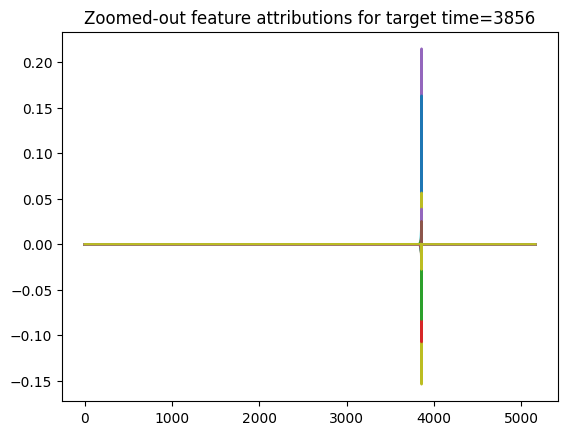

In [128]:
for f in range(49):
    plt.plot(attr_to_plot[f])
plt.title(f"Zoomed-out feature attributions for target time={target_index}")
plt.show()

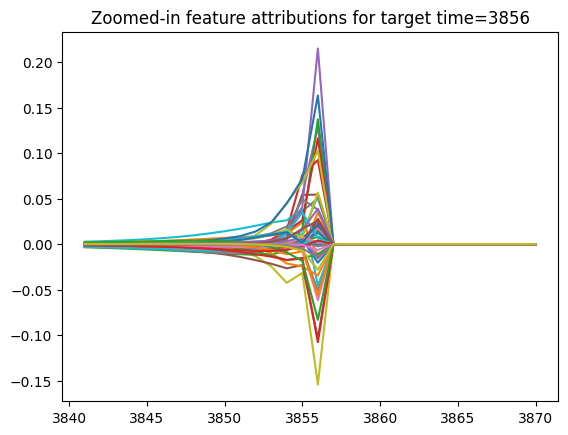

In [129]:
neighborhood = 15
for f in range(49):
    plt.plot(range(target_index-neighborhood, target_index+neighborhood), attr_to_plot[f, target_index-neighborhood:target_index+neighborhood], label=feature_names[f])
plt.title(f"Zoomed-in feature attributions for target time={target_index}")
#plt.legend()
plt.show()

### <span style="color:red"> Conclusion: after trying out different values for target_index we can conclude that the LSTM model uses on average 10 time samples before t=T to make the prediction at time t=T. Given that our training dataset was computed for a time resolution of 0.5 seconds, we can say that the LSTM takes advantage of 10x0.5, i.e. 5 seconds to make the prediction at a specific point.</span>

### <span style="color:red">Note however that the LSTM was not trained with a window size of 10. The history data was the full length of the dataset. So the LSTM learned that 10 samples is an optimal amount to make the prediction (given the amount of training data that was available and the neurons it could afford to train, constrained by this amount of available train data). </span>

### Further Analysis

In [130]:
attr_to_analyze = attributions.detach().cpu().numpy()[0].T
print(attr_to_analyze.shape)

(49, 5162)


In [131]:
target_sample = attr_to_analyze[:, target_index]

In [132]:
print(len(target_sample))
print(target_sample)

49
[-1.02753143e-04  3.48872964e-02  1.50000093e-02  2.77231318e-02
  1.98942908e-02  2.25901008e-02  1.72164585e-02  5.03088488e-02
 -1.54175042e-01  5.31103385e-02  1.22384926e-02  3.94140736e-03
  8.19824302e-03  9.23601515e-02  1.28815594e-01  5.44912260e-02
 -6.15542822e-02 -5.09990274e-02  1.75099053e-03 -4.55612036e-02
 -2.03438165e-02 -1.29965785e-02  1.37147375e-01  1.16237926e-01
  2.14989441e-01 -1.03426313e-01 -1.59601458e-02  3.77839062e-02
  1.02714597e-01  6.78492171e-03  1.63322108e-01 -3.44313670e-02
 -1.08269105e-02 -1.07756325e-01 -1.47288413e-02  2.07585998e-02
  1.56897700e-03 -2.35969778e-03  5.66133355e-02  3.20614985e-03
  2.27011729e-02 -5.62977139e-02 -8.31350351e-02  3.85641199e-03
  3.89825188e-02  2.54453629e-02 -6.32536735e-03 -1.50303868e-02
 -2.81165689e-02]


In [133]:
positive_features = target_sample >= 0
print(positive_features)

[False  True  True  True  True  True  True  True False  True  True  True
  True  True  True  True False False  True False False False  True  True
  True False False  True  True  True  True False False False False  True
  True False  True  True  True False False  True  True  True False False
 False]


In [134]:
negative_features = target_sample < 0

In [135]:
print(f"Num of positive features={positive_features.sum()}")

Num of positive features=30


In [136]:
print(f"Num of negative features={negative_features.sum()}")

Num of negative features=19


In [137]:
assert positive_features.sum() + negative_features.sum() == 49, "Total number of features with positive and negative attribution is not 49 as it should be!"

In [138]:
feature_names_np = np.array(feature_names)
#print(feature_names_np)
positive_impact_values = target_sample[positive_features]
negative_impact_values = target_sample[negative_features]
positive_feature_names = feature_names_np[positive_features]
negative_feature_names = feature_names_np[negative_features]

#print("Positive impact values: ", positive_impact_values)
#print("Positive impact feature names: ", positive_feature_names)
#print("Negative impact values: ", negative_impact_values)
#print("Negative impact feature names: ", negative_feature_names)

# Create the dictionary of key-value pairs so that we can sort later the attribution values and keep track of their corresponding feature name keys. 
# This will be useful for plotting.

positive_attributions_dict = dict(zip(positive_feature_names, positive_impact_values))
negative_attributions_dict = dict(zip(negative_feature_names, negative_impact_values))

ordered_positive_attributions_dict = {k: v for k, v in sorted(positive_attributions_dict.items(), key=lambda item: item[1])}
print("positive attributions dictionary: ", positive_attributions_dict, "\n")
print("ordered positive attributions dictionary: ", ordered_positive_attributions_dict, "\n")

ordered_negative_attributions_dict = {k: v for k, v in sorted(negative_attributions_dict.items(), key=lambda item: item[1])}
print("negative attributions dictionary", negative_attributions_dict, "\n")
print("ordered negative attributions dictionary: ", ordered_negative_attributions_dict)

positive attributions dictionary:  {'s0.5/w180/n_N': 0.034887296401386665, 's0.5/w23/n_N': 0.015000009293632, 's0.5/w45/n_N': 0.027723131815186573, 's0.5/w90/n_N': 0.0198942907935788, 's0.5/w180/rc5/c_C-VALUE': 0.022590100814238716, 's0.5/w45/rc10/c_C-VALUE': 0.017216458538494, 's0.5/w45/rc20/c_C-VALUE': 0.05030884876869661, 's0.5/w90/rc5/c_C-VALUE': 0.05311033846083833, 's0.5/w100/pfo_PFO': 0.012238492556976907, 's0.5/w25/pfo_PFO': 0.003941407359619363, 's0.5/w50/pfo_PFO': 0.008198243017423472, 's0.5/w100/pma_PMA': 0.09236015152609459, 's0.5/w25/pma_PMA': 0.12881559434567896, 's0.5/w50/pma_PMA': 0.054491226003494174, 's0.5/w10/b_B-VALUE': 0.0017509905340897963, 's0.5/w180/d2_D-VALUE': 0.13714737525554027, 's0.5/w45/d2_D-VALUE': 0.11623792618624433, 's0.5/w90/d2_D-VALUE': 0.21498944055981167, 's0.5/w100/trp_TRP': 0.03778390617688393, 's0.5/w25/trp_TRP': 0.10271459677687554, 's0.5/w50/trp_TRP': 0.006784921705697133, 's0.5/w100/trq_TRQ': 0.16332210782046985, 's0.5/w45/r_R': 0.02075859980

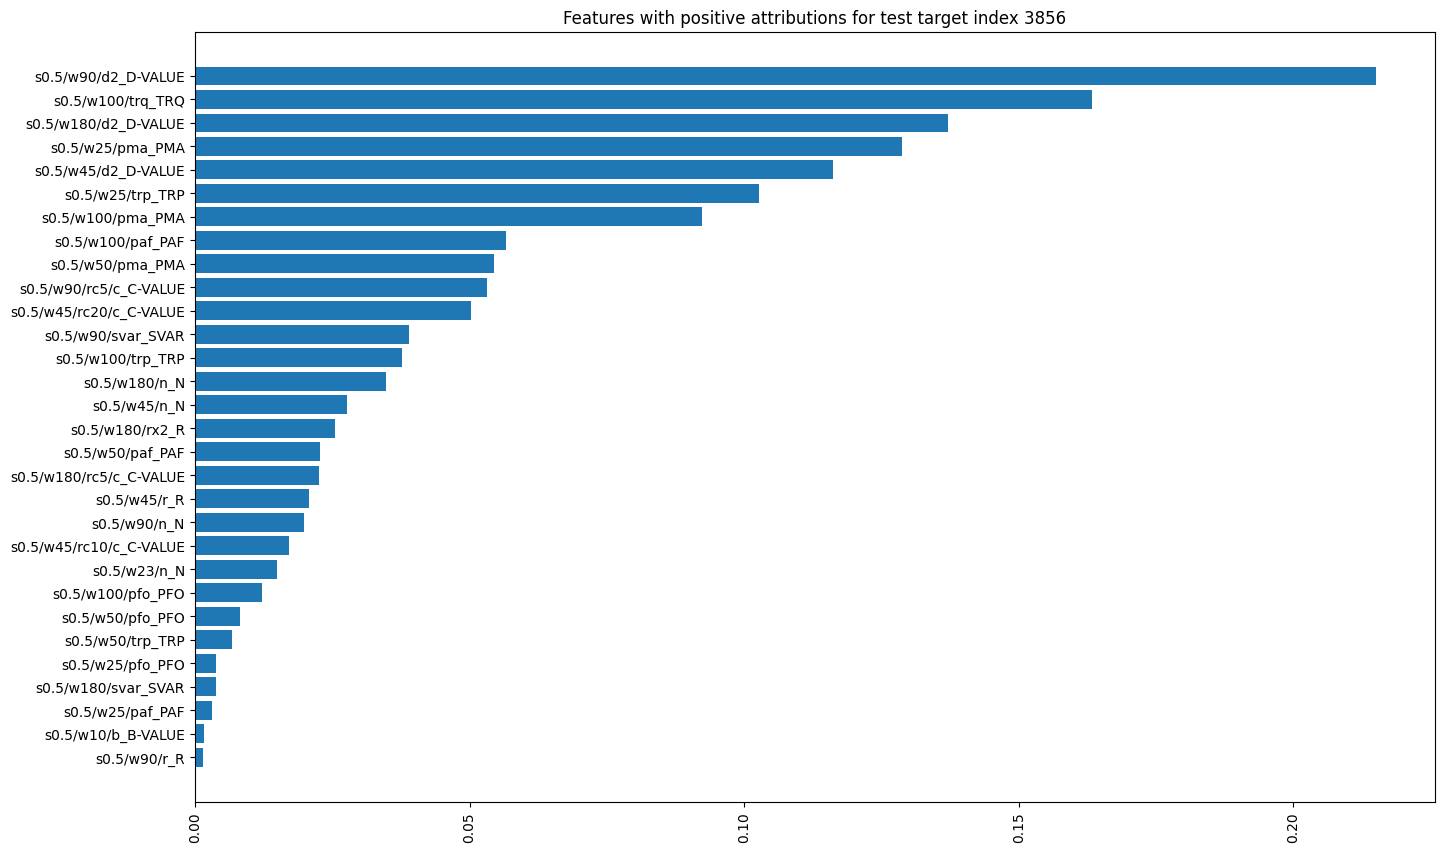

In [139]:
fig = plt.figure(figsize=(16, 10))
#plt.barh(positive_feature_names, positive_impact_values)
plt.barh(list(ordered_positive_attributions_dict.keys()), list(ordered_positive_attributions_dict.values()))
plt.xticks(rotation="vertical")
plt.title(f"Features with positive attributions for test target index {target_index}")

plt.savefig(f"../../cloudcontainer/experiments_related/testtarget_{target_index}_positive_attributions_fig.png")

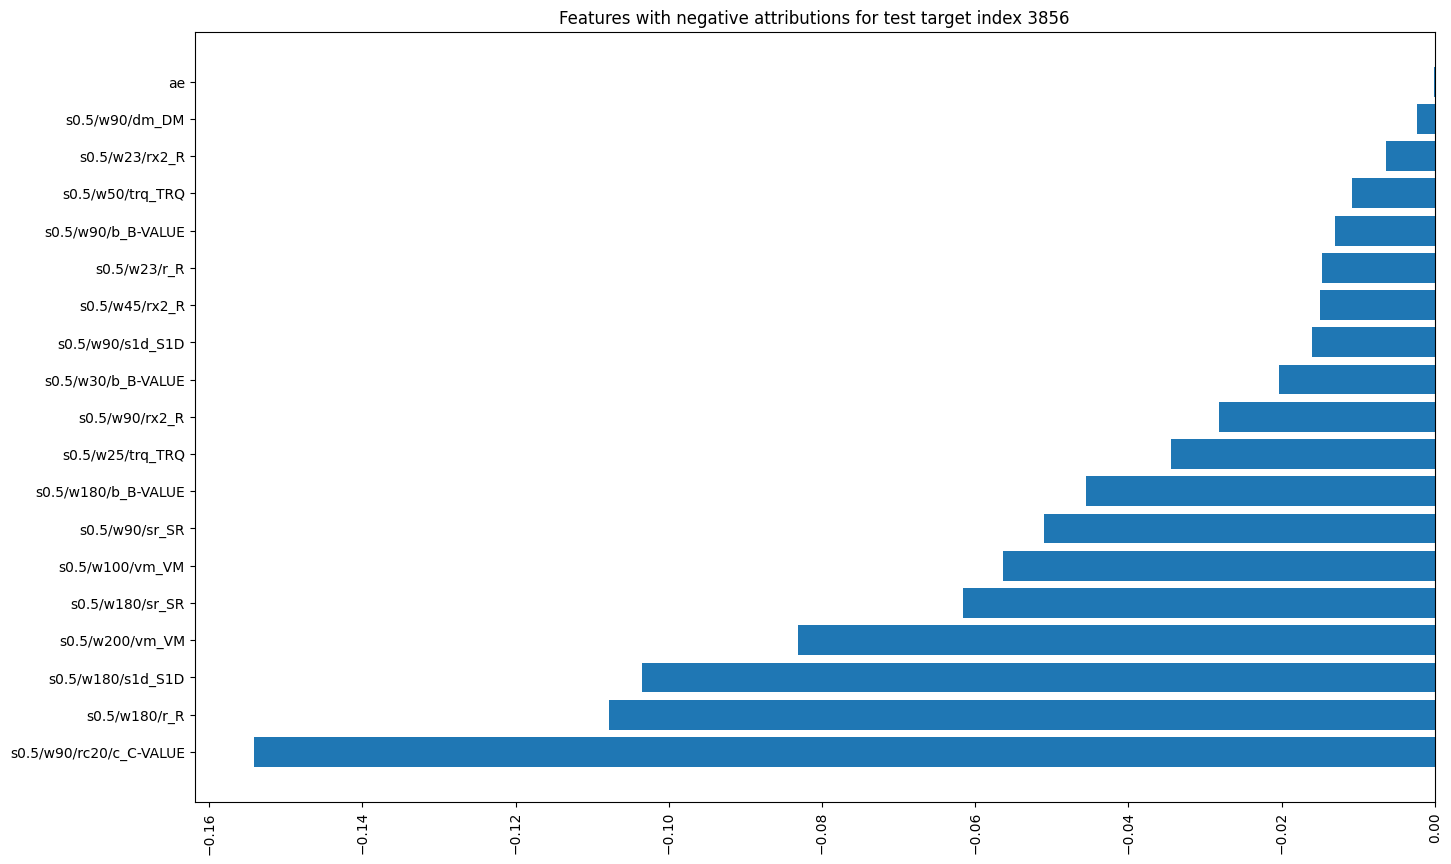

In [140]:
fig = plt.figure(figsize=(16, 10))
plt.barh(list(ordered_negative_attributions_dict.keys()), list(ordered_negative_attributions_dict.values()))
plt.xticks(rotation="vertical")
plt.title(f"Features with negative attributions for test target index {target_index}")

plt.savefig(f"../../cloudcontainer/experiments_related/testtarget_{target_index}_negative_attributions_fig.png")